# Digit Recognition using tensorflow - Kaggle

<h3 style='color:navy'>1.Import dependecies.</h3>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import animation
import time
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

C:\Users\ADMIN\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<h3 style='color:navy'>2.Reading data</h3>

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<h4>Perparing data and convert it to matrix.</h4>

In [4]:
train_x = train.drop(columns='label').as_matrix()
train_y = train['label'].as_matrix()
test_x = test.as_matrix()


print("The training features shape is {}".format(train_x.shape))

print("The training label shape is {}".format(train_y.shape))

print("The testing features shape is {}".format(test_x.shape))

The training features shape is (42000, 784)
The training label shape is (42000,)
The testing features shape is (28000, 784)


<h3 style='color:navy'>3.Creating functions needed for training.</h3>

In [5]:
def create_placeholders(input_shape, output_shape):
    
    '''
    This function for defining placeholders for both input and output.
    params:-
        input_shape : Input shape - type: int.
        output_shape: Output shape - type: int.
    return:-
        tensors of features(input) and output(labels).   
    '''
    features = tf.placeholder(dtype=tf.float32, shape=[None, input_shape], name='features')
    
    labels = tf.placeholder(dtype=tf.int32, shape=[None, output_shape], name='labels')
    
    return features, labels 

In [6]:
def inialize_weights(num_of_layers, num_of_nodes):
    '''
    This function for inializing weights and bias.
    Params:-
        num_of_layers: The number of hidden layers + the input layer + the output layer.
        num_of_nodes : The number of nodes for each layer.
        
    Output: 
        return weights: dictionary of weights and bias. 
    '''
    
    weights = {}
    # Loop through number of layers
    with tf.variable_scope("Weights", reuse=tf.AUTO_REUSE):
        for i in range(num_of_layers-1):

            # Create names for each layer
            name_w = 'w{}'.format(i) 
            name_b = 'b{}'.format(i)

            weights[name_w] = tf.get_variable(name_w, initializer=tf.contrib.layers.xavier_initializer(
            uniform=True,
            seed=None,
            dtype=tf.float32), shape=(num_of_nodes[i], num_of_nodes[i+1]))

            weights[name_b] = tf.get_variable(name_b, initializer=tf.zeros(num_of_nodes[i+1]))
        
    return weights

In [7]:
def output(features, weights, num_of_hiddens, keep_prop):
    '''
    This fuction for calculate output for each layer to the last output without
    runing an activation fuction.
    Params:-
        features      : The input - matrix.
        weights       : Dictionary contains weights and biases - tensors.
        num_of_hiddens: The number of hidden layers - int.
        keep_prop     : The ratio of keeping data to be trained. type: float.
    
    output:
        returns logits for the output layer - tensor.
    '''
    # Compute the output for the first layer.
    out = tf.nn.relu(tf.add(tf.matmul(features, weights['w0']), weights['b0']))
    
    # Loop through the hidden layers.
    for i in range(1, num_of_hiddens):
        
        name_w = 'w{}'.format(i)
        name_b = 'b{}'.format(i)
        
        # Calculate the output for one layer.
        out = tf.nn.relu(tf.add(tf.matmul(out, weights[name_w]), weights[name_b]))
        
        # Add the dropout to the layer.
        out = tf.nn.dropout(out,keep_prob=keep_prop)
    
    # Compute the logits for the output layer.
    return tf.add(tf.matmul(out, weights['w{}'.format(num_of_hiddens)]), weights['b{}'.format(num_of_hiddens)])
    

In [8]:
def optimizer(logits, labels, lr=.001):
    '''
    This function to compute cost function and optimize cost and calculate accuracy.
    Params:-
        logits: Tensors of logits for the output layer before softmax.
        labels: Tensors of labels.
        lr    : The learning rate.
    returns:
        train_op: train optimizers.
        accuracy: The accuracy of training model.
    
    '''
    # Calculate the cost.
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits))
    
    # Define optimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    
    # Optimize the cost.
    train_op = optimizer.minimize(cost)
    
    # Calculate the number of correct prediction.
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    
    # Calculate accuracy.
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    
    return train_op, accuracy


In [9]:
def get_batches(X, Y, batch_size):
    '''
    Using Dataset class for creating batches with repeat 1000 times
    this allows for inifinity repeating our data. this number isn't 
    fixed, it is related to your dataset size.
    Params:-
        X         : Features of the data.
        Y         : Labels of the data.
        batch_size: The size of data in each iteration.
        
    returns:
        iterator, next_row.
    
    '''
    
    dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat(10000).batch(batch_size)
    iterator = dataset.make_initializable_iterator()
    next_row = iterator.get_next()
    return iterator, next_row

In [10]:
def split_data(X, Y, split_ratio, is_normalized=True):
    '''
    This function for spliting the data into training set andvalidation set.
    Params:
        X            : Features of all data - type: matrix.
        Y            : Labels of the X data - type: matrix.
        split_ratio  : define the ratio of testing set from whole data - float.
        is_normalized: To determine if you want the data normaized or not - type: bool. Default: True.
    Output:
        returns train_x, train_y, val_x, val_y.
    '''
    
    
    # If normaized.
    if is_normalized:
        X = (X - X.mean())/X.std()
        
    # Split the data.    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split_ratio, random_state=42)
    
    return X_train, X_test, Y_train, Y_test

In [11]:
def one_hot(data, depth):
    '''
    this function for concerting to hot vector.
    Params:
        data: the data needed to be coverted- type: vector.
        depth: the number of classes.
    returns:
        tensor of the new data.
    '''
    data = tf.one_hot(data, depth=depth)
    return data

In [12]:
def plot(num_of_iterations):
    '''
    This functio for create and save aimated plot.
    Params:
        num_of_iterations: The number of iterations for the training process.
    returns:
         fig, writer.
        
    '''
    
    #Inialize writer. ffmpeg is used.
    Writer = animation.writers['ffmpeg']
    # Define frame per second parameter, metadata, and bitrate.
    writer = Writer(fps=20, metadata=dict(artist='Zynab'), bitrate=1800)

    #Inilize the figure
    fig = plt.figure(figsize=(10,6))
    plt.xlim(0, num_of_iterations)
    plt.ylim(0, 1.2)
    plt.xlabel('Number of iterations', fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.title('Training and testing accuracy vs iterations.', fontsize=20)
    plt.grid()
    return (fig, writer)

def animate(i):
    '''
    The function that will be called according to the number
    we define.
    '''
    
    x = np.arange(0, num_of_iterations+100, 100)
    p = sns.lineplot(x=x[:int(i+1)], y=training_acc[:int(i+1)], color='g')
    p.tick_params(labelsize=17)
    plt.setp(p.lines,linewidth=4)
    
    pp = sns.lineplot(x=x[:int(i+1)], y=validation_acc[:int(i+1)], color='r')
    pp.tick_params(labelsize=17)
    plt.setp(pp.lines,linewidth=4)
    plt.legend(labels=['Training', 'Validation'], loc='lower right')


In [27]:
def create_animation(num_of_models, num_of_iterations):
    '''
    This fumction for create the animated video for the accuracy.
    Params:-
        num_of_models: The count number of the trained models - type: int.
        fig : Has the configuration for the figure.
        writer: used to write the frames of the video.
    
    '''
    
    
    # The new name for the new model.
    animation_name= ".//my_models//model_{}_animatedAcc.mp4".format(num_of_models)
    fig, writer = plot(num_of_iterations)    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=num_of_iterations//100+1, repeat=True)
    ani.save(animation_name, writer=writer)
    
    

In [32]:
def save_info_about_the_model(num_of_layers, num_of_hiddens, num_of_nodes, lr, 
                              num_of_iterations, batch_size, training_acc, validation_acc, num_of_model):
    
    '''
    This function to save hyperparameters of the model.
    Params:
            num_of_layers    : Number of all layers - type: int.
            num_of_hiddens   : Number of hidden layer excluding input and output layer - 
                               type: int.
            num_of_nodes     : Number of nodes for each layer - type: list.
            lr               : Learning rate. 
            num_of_iterations: Number of iteration to train the model - type: int.
            batch_size       : The batch size - type: int.
            training_acc     : The last training acc the model gets - type: int.
            validation_acc   : The last validation acc the model gets - type: int. 
            num_of_model     : The count of training model to keep the data related to each
                               model sperate from other models.
    
    '''
    
    # This to save the information related to model in another file.
    file_name = './/my_models//model_{}_info.txt'.format(num_of_model)
    file = open(file_name, 'a')
    
    info = """The number of all layers is {}.\nThe number of hidden layers is {}.\nThe number of nodes is {}.
The learning rate is {}.\nThe number of iterations is {}.\nThe batch size is {}.\nThetraining acc is {}.
The testing acc is {}.""".format(num_of_layers, num_of_hiddens, num_of_nodes, lr,
                                   num_of_iterations, batch_size, training_acc, validation_acc)
    
    file.write(info)
    file.close()
    
    

<h3 style='color:navy'>4.Setting Hyperparameters</h3>

In [25]:
"""
NEVER CHANGE THIS PART
"""
num_of_models = 1

In [31]:
input_shape = train_x[0].shape[0]
output_shape = 10
num_of_layers = 3 # Number of all layers including input and output layer.
num_of_nodes = [input_shape, 300, output_shape]
num_of_hiddens = 1 # Number of hidden layers regardless of input and output layer.
lr = .001 # Learning rate.
split_ratio = .1
X_train, X_val, Y_train, Y_val = split_data(train_x, train_y, split_ratio)
num_of_iterations = 40000
batch_size = 64
keep_prop = .7
predicts = [] # To save the predictions for the test data.

<h3 style='color:navy'>5.Calling functions to build gragh and start training.</h3>

In [15]:
# Reset the default graph
tf.reset_default_graph()

# Create placeholders for features and labels.
features, labels = create_placeholders(input_shape, output_shape)

# Intialize weights.
weights = inialize_weights(num_of_layers, num_of_nodes)

# Getting outout
logits = output(features, weights, num_of_hiddens, keep_prop)

# Calculate loss and optimize loss.
train_op, accuracy = optimizer(logits, labels, lr=lr)


# Initialize global variable.
init = tf.global_variables_initializer()

# Define saver to save the model.
saver = tf.train.Saver()

<h3 style='color:navy'>6.Running session</h3>

Iteration 1. === Training acc is 0.09375 == Validation acc is 0.22833333909511566.
Iteration 100. === Training acc is 0.90625 == Validation acc is 0.9038095474243164.
Iteration 200. === Training acc is 0.953125 == Validation acc is 0.9292857050895691.
Iteration 300. === Training acc is 0.921875 == Validation acc is 0.9350000023841858.
Iteration 400. === Training acc is 0.953125 == Validation acc is 0.9469047784805298.
Iteration 500. === Training acc is 0.96875 == Validation acc is 0.9483333230018616.
Iteration 600. === Training acc is 0.953125 == Validation acc is 0.9530952572822571.
Iteration 700. === Training acc is 0.96875 == Validation acc is 0.9566666483879089.
Iteration 800. === Training acc is 0.984375 == Validation acc is 0.9604762196540833.
Iteration 900. === Training acc is 0.984375 == Validation acc is 0.9585714340209961.
Iteration 1000. === Training acc is 0.96875 == Validation acc is 0.961904764175415.
Iteration 1100. === Training acc is 0.984375 == Validation acc is 0.961

Iteration 9900. === Training acc is 0.984375 == Validation acc is 0.9735714197158813.
Iteration 10000. === Training acc is 1.0 == Validation acc is 0.9740476012229919.
Iteration 10100. === Training acc is 1.0 == Validation acc is 0.9730952382087708.
Iteration 10200. === Training acc is 1.0 == Validation acc is 0.9764285683631897.
Iteration 10300. === Training acc is 1.0 == Validation acc is 0.9740476012229919.
Iteration 10400. === Training acc is 1.0 == Validation acc is 0.9730952382087708.
Iteration 10500. === Training acc is 1.0 == Validation acc is 0.9752380847930908.
Iteration 10600. === Training acc is 1.0 == Validation acc is 0.9740476012229919.
Iteration 10700. === Training acc is 0.953125 == Validation acc is 0.9769047498703003.
Iteration 10800. === Training acc is 0.984375 == Validation acc is 0.9702380895614624.
Iteration 10900. === Training acc is 1.0 == Validation acc is 0.9745237827301025.
Iteration 11000. === Training acc is 1.0 == Validation acc is 0.9740476012229919.
It

Iteration 19900. === Training acc is 0.984375 == Validation acc is 0.9735714197158813.
Iteration 20000. === Training acc is 1.0 == Validation acc is 0.9759523868560791.
Iteration 20100. === Training acc is 1.0 == Validation acc is 0.9776190519332886.
Iteration 20200. === Training acc is 1.0 == Validation acc is 0.9730952382087708.
Iteration 20300. === Training acc is 1.0 == Validation acc is 0.9742857217788696.
Iteration 20400. === Training acc is 0.984375 == Validation acc is 0.9752380847930908.
Iteration 20500. === Training acc is 1.0 == Validation acc is 0.9747619032859802.
Iteration 20600. === Training acc is 1.0 == Validation acc is 0.9728571176528931.
Iteration 20700. === Training acc is 0.984375 == Validation acc is 0.9745237827301025.
Iteration 20800. === Training acc is 1.0 == Validation acc is 0.9742857217788696.
Iteration 20900. === Training acc is 1.0 == Validation acc is 0.9757142663002014.
Iteration 21000. === Training acc is 1.0 == Validation acc is 0.9726190567016602.
I

Iteration 29900. === Training acc is 1.0 == Validation acc is 0.977142870426178.
Iteration 30000. === Training acc is 1.0 == Validation acc is 0.9757142663002014.
Iteration 30100. === Training acc is 1.0 == Validation acc is 0.9773809313774109.
Iteration 30200. === Training acc is 1.0 == Validation acc is 0.9790475964546204.
Iteration 30300. === Training acc is 1.0 == Validation acc is 0.9788095355033875.
Iteration 30400. === Training acc is 1.0 == Validation acc is 0.9766666889190674.
Iteration 30500. === Training acc is 1.0 == Validation acc is 0.9780952334403992.
Iteration 30600. === Training acc is 1.0 == Validation acc is 0.9754762053489685.
Iteration 30700. === Training acc is 1.0 == Validation acc is 0.9759523868560791.
Iteration 30800. === Training acc is 1.0 == Validation acc is 0.9752380847930908.
Iteration 30900. === Training acc is 1.0 == Validation acc is 0.9783333539962769.
Iteration 31000. === Training acc is 1.0 == Validation acc is 0.9776190519332886.
Iteration 31100. 

Iteration 39900. === Training acc is 1.0 == Validation acc is 0.9764285683631897.
Iteration 40000. === Training acc is 1.0 == Validation acc is 0.9785714149475098.


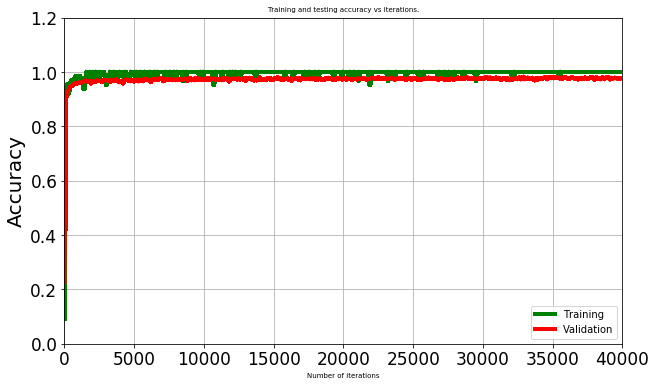

In [33]:
with tf.Session() as sess:
    
    # Define the training and testing acc.
    training_acc = []
    validation_acc = []
    
    # Convert the labels (y) to y hot vector.
    y_train_hot = sess.run(one_hot(Y_train, 10))
    y_val_hot = sess.run(one_hot(Y_val, 10))
    
    # Get the interator and generator for geting batches needed for training.
    iterator, next_batch = get_batches(X_train, y_train_hot, batch_size)
    
    sess.run([init, iterator.initializer])
    
    for i in range(1, num_of_iterations+1):
        
        x, y = sess.run(next_batch)
        
        _, acc = sess.run([train_op, accuracy], feed_dict={features:x, labels:y})
        
        
        if i % 100 == 0 or (i == 1):
            
            # Append the training accuracy to the training list.
            training_acc.append(acc)
        
            # Append val accuracy to the val_acc list.
            acc_val = sess.run(accuracy, feed_dict={features:X_val, labels:y_val_hot})
            validation_acc.append(acc_val)
            print("Iteration {}. === Training acc is {} == Validation acc is {}.".format(i, acc, acc_val))
    
    
    
    # Save the model.
    model_name = ".//my_models//model_{}".format(num_of_models)
    saver.save(sess, model_name)
    
    # Save hyperparameters.
    save_info_about_the_model(num_of_layers, num_of_hiddens, num_of_nodes, lr, 
                              num_of_iterations, batch_size, training_acc[-1], 
                              validation_acc[-1], num_of_models)
                    
    # Create the aimated video.
    create_animation(num_of_models, num_of_iterations)
    
    # Ouput the test data
    predicts = tf.argmax(sess.run(logits, feed_dict={features: test_x}), 1)
    
    # Add one the 'num_of_models'.
    num_of_models +=1
        
    

<h3 style='color:navy'>7.Perparing the submission file and saving it.</h3>

In [191]:
with tf.Session() as sess:
    submission = pd.DataFrame(data = sess.run(predicts), columns=['Label'], index=test.index)
    submit_file_name = ".//my_models//submit_{}.csv".format(nu)
    submission.to_csv(submit_file_name, index_label='ImageId')